# Purpose:

2015-02-27 (Friday)

Brief introduction to our problem of identifying SNP-pairs of interest based on linkage disequalibrium (LD) in _Glossina fuscipes fuscipes_ and my work so far.

# Introduction: #

## Linkage disequilibrium ##

Briefly, linkage disequilibrium is the co-occurrence of pairs of alleles within chromosomes in a population at frequencies more elevated or depressed than would be expected if given the overall frequencies of each allele in the population assuming completely random assortment between alleles.  However, alleles are __not__ able to assort in a completely random fashion. In reality, the distance between loci is _inversely proportional_ to the rate of recombination ("mixing") between chromosomal loci. So LD values can not be directly compared between arbitrary groups of allele-pairs.  One must either know the species-specific recombination rate or restrict comparisons to pairs with similar distances and thereby roughly fix the rates of recombination being compared.

## _Glossina fuscipes fuscipes_ ##


We do not know the recombination rate of _G. f. fuscipes_.  Therefore the methods that I have employed below have focused on controlling the effect of variable recombination rates by constructing bins of SNP-pairs that are located on contiguous chromosomal contigs (__not__ considering phasing or diploid/haploid membership) and have similar distances.  For example all SNP-pairs separated by the interval on a supercontig of $[i,j)$ where $|i-j| \sim 100$.

# Sections of interest



- [Plot distributions of $r^2$ for various bins](#Plot-distributions-of-$r^2$-for-various-bins)


- [First thoughts and notes about first thoughts](#First-thoughts-and-notes-about-first-thoughts:)


- [Generate functions to simulate data from the types of distributions we will be using](#Generate-functions-to-simulate-data-from-the-types-of-distributions-we-will-be-using:)


- [Build models for learning the distribution parameters](#Build-models-for-learning-the-distribution-parameters)  
    
    - [Exponential](#Exponential)
        - [Results of Exponential excersise](#Results-of-Exponential-excersise:)
    
    - [Beta](#Beta)

# Implementation:

## Imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import ggplot as gp


import numpy as np
import pandas as pd
# import tables as h5

import itertools as it
from collections import defaultdict

import numpy as np
import pandas as pd
import scipy
from scikits import bootstrap as bs
import statsmodels.api as sm

import munch

import pymc as mc

In [2]:
# set figure size
plt.rcParams['figure.figsize'] = np.array([16, 12]) * 0.65

## File paths:

In [3]:
# define paths to files
ld_table = "/home/gus/remote_mounts/louise/data/genomes/glossina_fuscipes/annotations/SNPs/plink_out/tsetseFINAL_14Oct2014_f2_53.recode.renamed_scaffolds.maf0_05.vcf/ld/r_none_freqs_dprime.ld"

### Define some functions to help us out:

In [4]:
def get_snps_with_same_distance(df, d, win=100):
    lbound = d - win
    rbound = d + win
    
    if lbound < 0:
        lbound = 0
    
    return df[(df.BP_DELTA >= lbound) & (df.BP_DELTA <= rbound)]

In [5]:
def get_snps_grouped_by_distances(df, ds, win=100):
    assert isinstance(ds, list)
    assert all([isinstance(d, int) for d in ds])
    
    groups = {}
    
    for d in ds:
        groups[d] = get_snps_with_same_distance(df=df, d=d, win=win)
        
    return groups

In [6]:
def collect_window_stat(df, upper_lim=1000, win=10,
                        stat_name="window_mean_r2", stat_func=np.mean,
                        return_df=True
                       ):
    
    
    data = {stat_name: [], 
            'd': np.array(range(upper_lim))+1}

    
    for d  in data['d']:
        data[stat_name].append(stat_func(get_snps_with_same_distance(df=df, d=d-1, win=win).R2))

    if return_df:
        return pd.DataFrame(data)
    else:
        return data

In [7]:
def modified_z_scores(observations):
    
    M_i = (observations - np.median(observations)) / smad(observations)
    
    return M_i

def update_mad_z(df):
    assert isinstance(df, pd.DataFrame)
    
    # add/overwrite mad_z column 
    df['mad_z'] = 'loco'
    
    for d in df.distance_bin.unique():
        d_mask = df.distance_bin == d
        df.loc[d_mask, 'mad_z'] = modified_z_scores(df.R2[d_mask])
        
    # sanity check
    assert 'loco' not in df.mad_z

In [8]:
def get_snps_in_bin_mask(df, d, win=100):
    
    lbound = d
    rbound = d + win

    return (df.BP_DELTA >= lbound) & (df.BP_DELTA <= rbound)


def update_distance_bin(df, win=100):

    assert isinstance(df, pd.DataFrame)

    # get bin definitions
    longest_d = df.BP_DELTA.max()  # teehee

    ds = xrange(0, longest_d, win)

    # add/overwrite distance_bin column 
    df['distance_bin'] = -1
    df['distance_bin_mean_R2'] = -1
    df['distance_bin_median_R2'] = -1
    
    for d in ds:
        bin_mask = get_snps_in_bin_mask(df=df, d=d, win=win)
        df.loc[bin_mask, 'distance_bin'] = d
        df.loc[bin_mask, 'distance_bin_mean_R2'] = df[bin_mask].R2.mean()
        df.loc[bin_mask, 'distance_bin_median_R2'] = df[bin_mask].R2.median()
    
    # sanity check
    assert df['distance_bin'].min() >= 0
    assert df['distance_bin_mean_R2'].min() >= 0
    assert df['distance_bin_median_R2'].min() >= 0

## Load table and do preliminary calculations: 

In [9]:
ld = pd.read_table(ld_table, sep=" +", engine='python')
ld['R2'] = ld.R**2
ld['BP_DELTA'] = abs(ld.BP_A - ld.BP_B)

In [10]:
# quick preview of data
ld.head()

,CHR_A,BP_A,SNP_A,MAF_A,CHR_B,BP_B,SNP_B,MAF_B,R,DP,R2,BP_DELTA
0,Scaffold0,13388,.,0.278846,Scaffold0,23408,.,0.298077,1.000000,1,1.000000,10020
1,Scaffold0,13388,.,0.278846,Scaffold0,23418,.,0.298077,1.000000,1,1.000000,10030
2,Scaffold0,13388,.,0.278846,Scaffold0,23421,.,0.298077,1.000000,1,1.000000,10033
3,Scaffold0,13388,.,0.278846,Scaffold0,23431,.,0.288462,0.975946,1,0.952471,10043
4,Scaffold0,13388,.,0.278846,Scaffold0,30544,.,0.094340,0.464238,1,0.215517,17156


In [11]:
ld.head()

,CHR_A,BP_A,SNP_A,MAF_A,CHR_B,BP_B,SNP_B,MAF_B,R,DP,R2,BP_DELTA
0,Scaffold0,13388,.,0.278846,Scaffold0,23408,.,0.298077,1.000000,1,1.000000,10020
1,Scaffold0,13388,.,0.278846,Scaffold0,23418,.,0.298077,1.000000,1,1.000000,10030
2,Scaffold0,13388,.,0.278846,Scaffold0,23421,.,0.298077,1.000000,1,1.000000,10033
3,Scaffold0,13388,.,0.278846,Scaffold0,23431,.,0.288462,0.975946,1,0.952471,10043
4,Scaffold0,13388,.,0.278846,Scaffold0,30544,.,0.094340,0.464238,1,0.215517,17156


In [12]:
update_distance_bin(ld, win=100)

In [13]:
ld.head()

,CHR_A,BP_A,SNP_A,MAF_A,CHR_B,BP_B,SNP_B,MAF_B,R,DP,R2,BP_DELTA,distance_bin,distance_bin_mean_R2,distance_bin_median_R2
0,Scaffold0,13388,.,0.278846,Scaffold0,23408,.,0.298077,1.000000,1,1.000000,10020,10000,0.114791,0.039473
1,Scaffold0,13388,.,0.278846,Scaffold0,23418,.,0.298077,1.000000,1,1.000000,10030,10000,0.114791,0.039473
2,Scaffold0,13388,.,0.278846,Scaffold0,23421,.,0.298077,1.000000,1,1.000000,10033,10000,0.114791,0.039473
3,Scaffold0,13388,.,0.278846,Scaffold0,23431,.,0.288462,0.975946,1,0.952471,10043,10000,0.114791,0.039473
4,Scaffold0,13388,.,0.278846,Scaffold0,30544,.,0.094340,0.464238,1,0.215517,17156,17100,0.098919,0.040782


## Plot distributions of $r^2$ for various bins

In [14]:
def plot_bin_dists(df, bin_def="distance_bin <= 500"):
    plt.rcParams['figure.figsize'] = np.array([16, 12]) * 0.65

    p = gp.ggplot(gp.aes(x='R2'), data=df.query(bin_def))
    p = p + gp.geom_histogram(fill='coral') + \
        gp.facet_wrap("distance_bin") + \
        gp.theme_seaborn(context='talk') + gp.ggtitle(bin_def)
    
    return p

/home/gus/.virtualenvs/py279/lib/python2.7/site-packages/ggplot/ggplot.py:200: RuntimeWarning: Facetting is currently not supported with geom_bar. See
                    https://github.com/yhat/ggplot/issues/196 for more information
  warnings.warn(msg, RuntimeWarning)
stat_bin: binwidth defaulted to range/30.
    Use 'binwidth = x' to adjust this.
/home/gus/.virtualenvs/py279/lib/python2.7/site-packages/pandas/util/decorators.py:81: FutureWarning: the 'rows' keyword is deprecated, use 'index' instead
  warnings.warn(msg, FutureWarning)
/home/gus/.virtualenvs/py279/lib/python2.7/site-packages/ggplot/geoms/geom_bar.py:47: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  _reset = self.bottom == None or (self.ax != None and self.ax != ax)


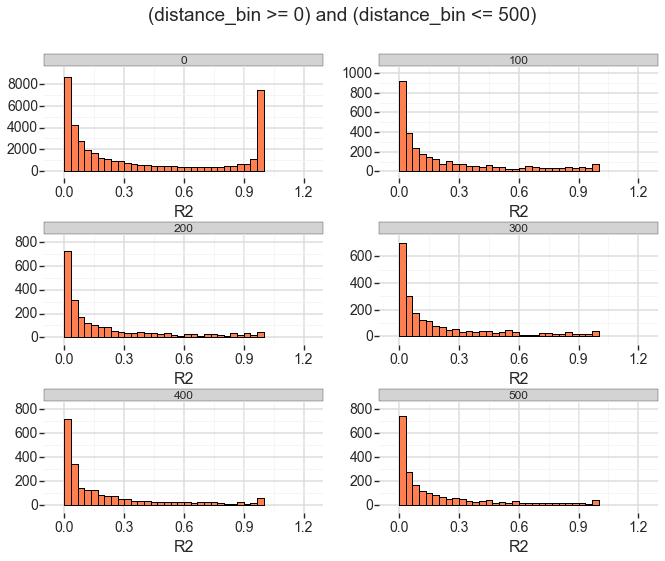

<ggplot: (8766351224757)>

In [15]:
plot_bin_dists(ld, bin_def="(distance_bin >= 0) and (distance_bin <= 500)")

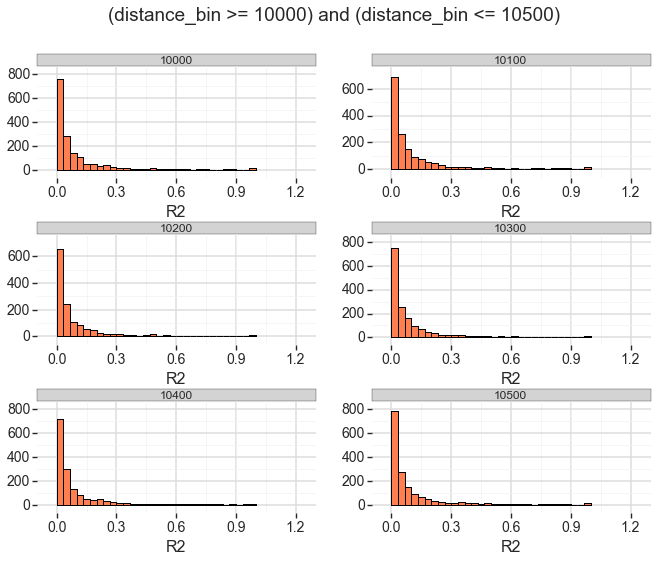

<ggplot: (8766300960049)>

In [16]:
plot_bin_dists(ld, bin_def="(distance_bin >= 10000) and (distance_bin <= 10500)")

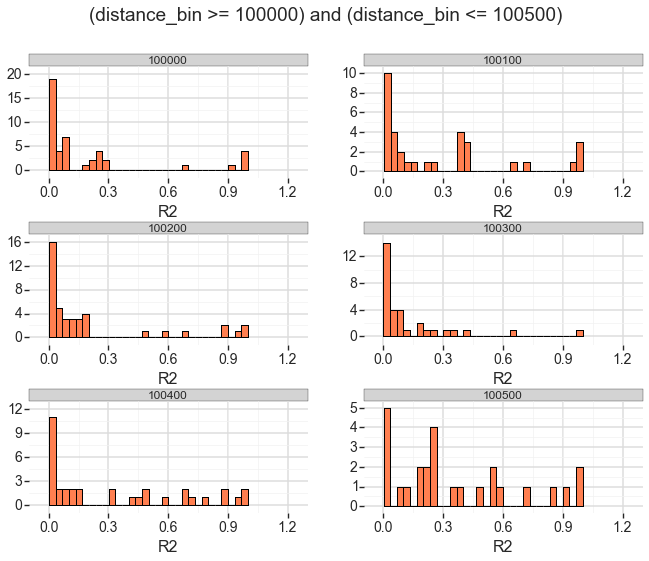

<ggplot: (8766311377109)>

In [17]:
plot_bin_dists(ld, bin_def="(distance_bin >= 100000) and (distance_bin <= 100500)")

# First-thoughts and notes about first-thoughts:

Where these data approximatly normal-looking one might use a z-score or modified z-score (_median absolute devation_ instead of std-dev) to set a semi-principled threshold for a value being considered "interesting".  But these are __not__ even a little "Normal" looking.

I then thought about using an Exponential distribution to model them but it can not accommodate the types of data we observe in the shorter distances which have concentrations at the high-end of the $r^2$ spectrum as well.  This may not be a big deal in practice, however?  The fact that the support for the Exponential distribution is $[0,\inf)$ while our data __can only__ occur over $[0,1]$ does bother me a bit though.

This has led me to the Beta distribution, which in its 2 parameter formulation ($\mathrm{Beta}(\alpha, \beta)$) only supports values over $(0,1)$.  However in a four parameter formulation ($\mathrm{Beta}(\alpha, \beta, a, c)$) accommodates values along $[a,c]$ by scaling linearly $[a,c]$ to within the Beta's normal support interval.

Below, I will go through what I have done to explore these distributions with our data.

----
# Generate functions to simulate data from the types of distributions we will be using:


## Simulate Exponential dist/data:

In [18]:
def sim_exponential(lamb):
    return scipy.stats.expon(scale=1./lamb)

In [19]:
def plot_exponential(lambda_params):
    plt.rcParams['figure.figsize'] = np.array([16, 12]) * 0.65
    with sns.color_palette("Set2",10):
        if isinstance(lambda_params, list):
            lambda_params = np.array(lambda_params)

        if isinstance(lambda_params, int) or isinstance(lambda_params, float):
            lambda_params = np.array([lambda_params])

        exponetial = scipy.stats.expon
        scale = 1./lambda_params

        for i, lamb in enumerate(lambda_params):

            x = np.linspace(exponetial.ppf(0.01, scale=scale[i]),
                          exponetial.ppf(0.99, scale=scale[i]), 100)
            plt.plot(x, exponetial.pdf(x, scale=scale[i]),
                     lw=2, 
                     label='$\lambda = {lamb}$ | scale = {scale}'.format(lamb=lamb,
                                                                         scale=scale[i]
                                                                         ))
        plt.xlim(0,1)
        plt.title("Exponential PDF(s)")
        plt.legend(loc='best', frameon=False)

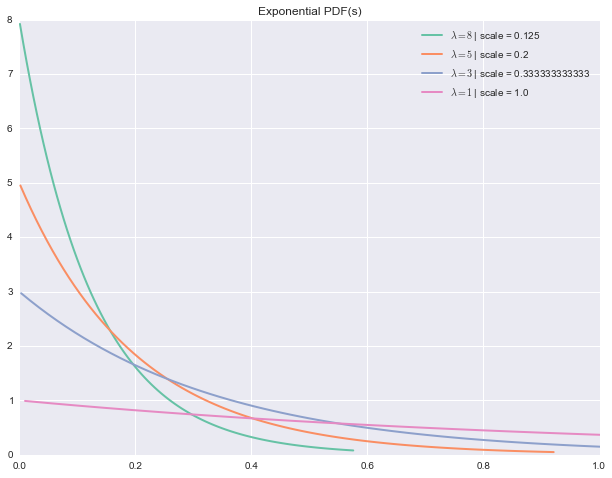

In [20]:
plot_exponential([8,5,3,1])
# plot_exponential(lambda_param)

## Simulate Beta dist/data:

In [21]:
def sim_beta(a,b):
    return scipy.stats.beta(a,b)

In [22]:
def plot_beta(a,b):
    plt.rcParams['figure.figsize'] = np.array([16, 12]) * 0.65
    with sns.color_palette("Set2",10):
        if isinstance(a, list):
            a = np.array(a)
        if isinstance(a, int) or isinstance(a, float):
            a = np.array([a])
            
        if isinstance(b, list):
            b = np.array(b)
        if isinstance(b, int) or isinstance(b, float):
            b = np.array([b])
        
        beta = scipy.stats.beta
        
        for i, v in enumerate(a):
            x = np.linspace(beta.ppf(0.01, a=a[i], b=b[i]),
                          beta.ppf(0.99, a=a[i], b=b[i]), 10000)
            plt.plot(x, beta.pdf(x, a=a[i], b=b[i]),
                     lw=2, label=r'$\alpha$ = {a}, $\beta$ = {b}'.format(a=a[i],b=b[i]))
            
        plt.title("Beta PDF(s)".format(a=a,b=b))
        plt.legend(loc='best', frameon=False)

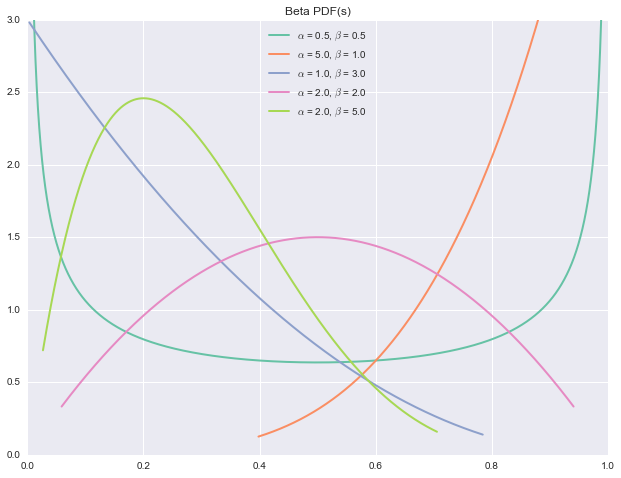

In [23]:
plot_beta([0.5,5,1,2,2],[0.5,1,3,2,5])
plt.ylim(0,3);

## Simulate Gamma dist/data:

In [24]:
def gamma_scale_to_rate(scale):
    return 1./scale

def gamma_rate_to_scale(rate):
    return 1./rate

def sim_gamma(a,b):
    scipy.stats.gamma(a=a, scale=gamma_rate_to_scale(b))

In [25]:
def plot_gamma(a,b):
    plt.rcParams['figure.figsize'] = np.array([16, 12]) * 0.65
    with sns.color_palette("Set2",10):
        if isinstance(a, list):
            a = np.array(a)
        if isinstance(a, int) or isinstance(a, float):
            a = np.array([a])
            
        if isinstance(b, list):
            b = np.array(b)
        if isinstance(b, int) or isinstance(b, float):
            b = np.array([b])
        
        gamma = scipy.stats.gamma
        
        thetas = gamma_rate_to_scale(b)
        
        for i, v in enumerate(a):
            x = np.linspace(gamma.ppf(0.01, a=a[i], scale=thetas[i]),
                          gamma.ppf(0.99, a=a[i], scale=thetas[i]), 10000)
            plt.plot(x, gamma.pdf(x, a=a[i], scale=thetas[i]),
                     lw=2, label=r'$\alpha$ = {a}, $\beta$ = {b} ($\theta$={theta})'.format(a=a[i],
                                                                                            b=b[i],
                                                                                            theta=thetas[i]))
            
        plt.title("Gamma PDF(s)")
        plt.legend(loc='best', frameon=False)
        
    return gamma

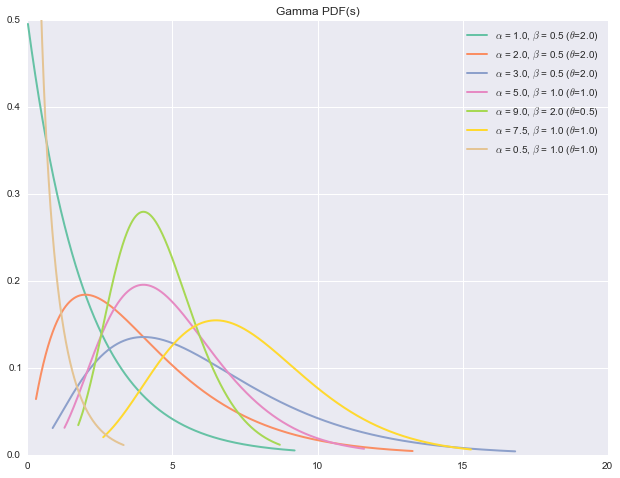

In [26]:
alphas = np.array([1,2,3,5,9  ,7.5,0.5])
thetas = np.array([2,2,2,1,0.5,1  ,1])
betas = gamma_scale_to_rate(thetas)

plot_gamma(alphas, betas)
plt.ylim(0,0.5);
plt.xlim(0,20);


# Build models for learning the distribution parameters

## Exponential

Approach:

1. Model the bin distribution as an exponential random variable $B$ with rate parameter $\lambda > 0$.
1. Model $\lambda$ as a Gamma random variable $L$.
    - Gamma dist fits $\lambda$'s support interval and is very flexible w.r.t. shape.
1. $\lambda$ can be estimated using the median of a true Exponential dist: 
$$\mathrm{median} = \frac{\ln({2})}{\lambda}$$
$$\lambda = \frac{\ln({2})}{\mathrm{median}}$$
1. The Gamma dist parameters ($\alpha$, $\beta$) will be set so that the expected value of the initial Gamma dist will be equal to the predicted $\lambda$:
$$\mathrm{E}[X]_{\mathrm{Gamma(\alpha,\beta)}} = \frac{\alpha}{\beta} = \frac{\ln({2})}{\mathrm{median}}$$

In [27]:
test_bin = ld.query("(distance_bin == 100)")

## Exponetial model of distance bin's $r^2$ with no learning: _completely naive_

In [28]:
# Estimate \lambda ~ ln(2)/median(test_bin)
naive_lambda = np.log(2)/test_bin.R2.median()
naive_lambda

6.3942904657547155

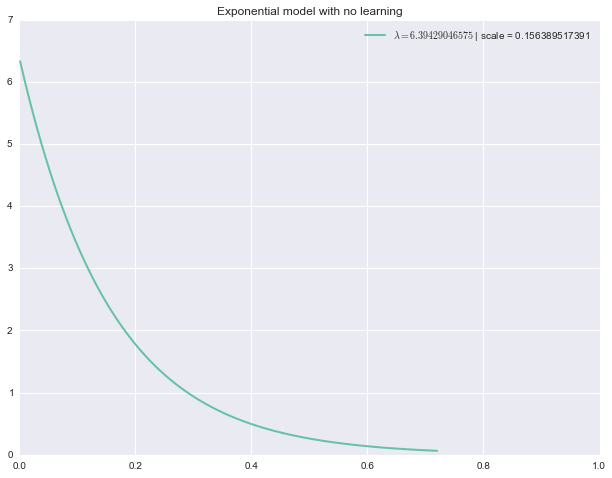

In [29]:
plot_exponential(naive_lambda)
plt.title("Exponential model with no learning");

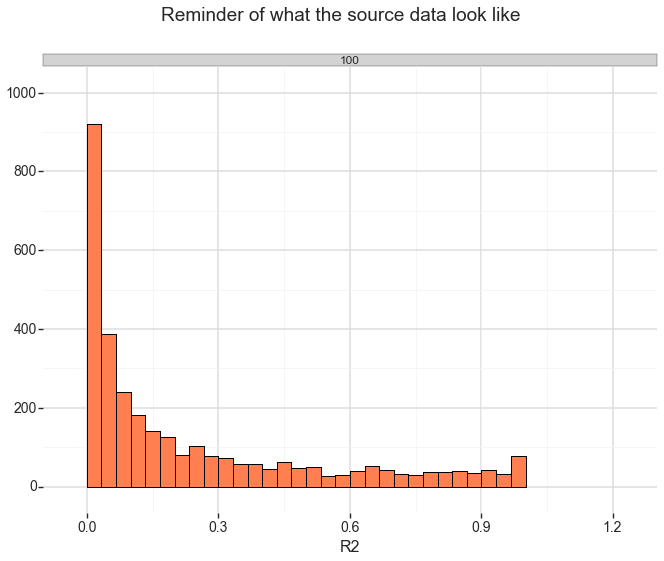

<ggplot: (8766351218157)>

In [30]:
plot_bin_dists(test_bin, bin_def="(distance_bin == 100)") + \
gp.ggtitle('Reminder of what the source data look like')

## Exponential model of distance bin's $r^2$ for MCMC learning:

For `pyMC` we must build model components separately and add them to the model proper. 

1. First we must model the Exponential's parameter $\lambda$. I have selected a Gamma distribution for this.
1. Then we will initialize the values of the Gamma distribution using the observed bin data. 
1. This model of the $\lambda$ parameter (`lambda_of_exponential`) will be added to the Exponential distribution model and the Exponential model will be assigned the observed data to use.  
1. Finally, we will execute both
    1. maximum a posteriori (MAP) and 
    1. Markov Chain Monte Carlo (MCMC)-based learning 
    
    to arrive at estimations of the $\lambda$ parameter value based on the observed data. 
1. And compare results.

###Modeling $\lambda$:

$$\mathrm{E}[X]_{\mathrm{Gamma(\alpha,\beta)}} = \frac{\alpha}{\beta}$$

$$\lambda_{\mathrm{est}} = \frac{\ln({2})}{\mathrm{median}(\mathrm{test\_bin})}$$

$$\mathrm{E}[X]_{\mathrm{Gamma(\alpha,\beta)}} = \frac{\ln({2})}{\mathrm{median}(\mathrm{test\_bin})}$$

$\mathrm{E}[X]_{\mathrm{Gamma(\alpha,\beta)}}$ is the expected value of the Gamma distribution in relation to $\alpha$ and $\beta$


$\lambda_{\mathrm{est}}$ is the value of $\lambda$ estimated from data alone


In [31]:
# set initial values of Gamma's alpha and beta to be E[X]_gamma(a,b)
alpha_of_gamma = np.log(2)
beta_of_gamma = test_bin.R2.median()

lambda_est = alpha_of_gamma/beta_of_gamma

print "alpha_of_gamma: {alpha_of_gamma}\nbeta_of_gamma: {beta_of_gamma}\nlambda_est: {lambda_est}".format(
    alpha_of_gamma=alpha_of_gamma,
    beta_of_gamma=beta_of_gamma,
    lambda_est=lambda_est)

alpha_of_gamma: 0.69314718056
beta_of_gamma: 0.108400953049
lambda_est: 6.39429046575


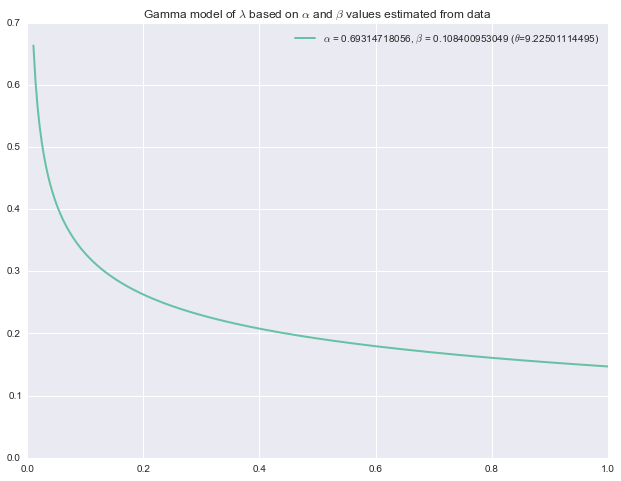

In [32]:
plot_gamma(alpha_of_gamma,beta_of_gamma)
plt.xlim(0,1)
plt.title(r'Gamma model of $\lambda$ based on $\alpha$ and $\beta$ values estimated from data');

In [33]:
lambda_of_exponential = mc.Gamma(name='lambda_of_exponential', alpha=alpha_of_gamma, beta=beta_of_gamma)
lambda_of_exponential.value = lambda_est
lambda_of_exponential.value

array(6.3942904657547155)

### Building the `pyMC` Exponential model:

In [34]:
r2_distribution_exponential = mc.Exponential("r2_distribution_exponential",
                                             beta=lambda_of_exponential,
                                             value=test_bin.R2, observed=True)

### Building the `pyMC` MCMC/MAP models with $r^2$ as Exponential:

In [35]:
bin_exponential_model = mc.Model([r2_distribution_exponential, lambda_of_exponential])

In [36]:
lambda_of_exponential_original = lambda_of_exponential.value
lambda_of_exponential_original

array(6.3942904657547155)

In [37]:
bin_exp_MAP = mc.MAP(bin_exponential_model)

In [38]:
bin_exp_MAP.fit()

In [39]:
lambda_of_exponential_after_MAP = lambda_of_exponential.value
lambda_of_exponential_after_MAP

array(4.122258151979902)

In [40]:
bin_exp_MCMC = mc.MCMC(bin_exponential_model)

In [41]:
bin_exp_MCMC.sample(iter=40000, burn=20000, thin=1)

 [-----------------100%-----------------] 40000 of 40000 complete in 27.9 sec

In [42]:
lambda_of_exponential_after_MCMC_from_MAP = lambda_of_exponential.value
lambda_of_exponential_after_MCMC_from_MAP

array(4.195743230061267)

In [43]:
bin_exponential_model_dag = mc.graph.dag(model=bin_exponential_model, format='jpg', prog='dot',
                                         path=None, name="bin_exponential_model", consts=True, legend=True, 
                                         collapse_deterministics=False, collapse_potentials=False, label_edges=True)

__Network graph of Exponential Model__


![](bin_exponential_model.jpg)

__Notes:__ 

- _`r2_distribution_exponential.beta`   is lambda_

- _`pyMC` treats Exponetial as special case of a Gamma when Gamma.alpha == 1_

### Results of Exponential excersise:

#### MCMC performance plots:

`pyMC` provides a graphical plot to assess the model's performance that plots three aspects of each learned variable:

1. The trace of the MCMC sampling
2. The histogram of the collected MCMC samples
3. The autocorrelation of the variable.

Plotting lambda_of_exponential


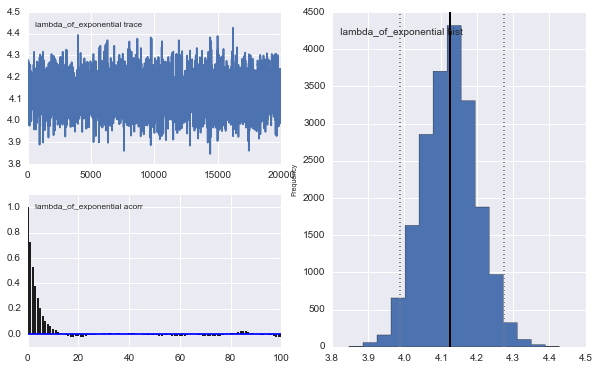

In [44]:
mc.Matplot.plot(bin_exp_MCMC)

#### Prob Density Functions of Exponential models parameterized with our different versions of $\lambda$:


lambda_of_exponential_original: 6.39429046575
lambda_of_exponential_after_MAP: 4.12225815198
lambda_of_exponential_after_MCMC_from_MAP: 4.19574323006


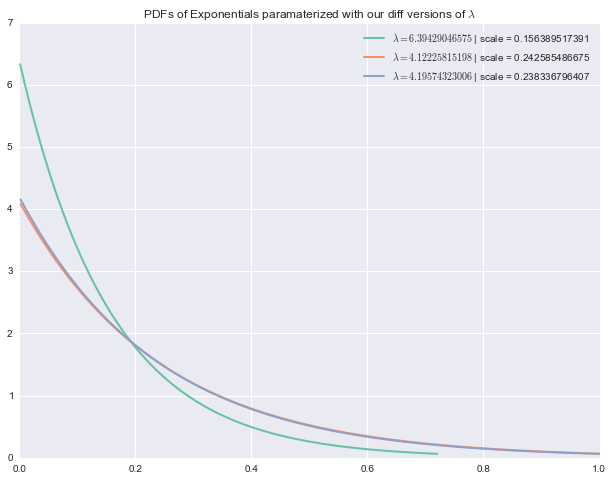

In [45]:
plot_exponential([lambda_of_exponential_original,
                 lambda_of_exponential_after_MAP,
                 lambda_of_exponential_after_MCMC_from_MAP
                ])
plt.title("PDFs of Exponentials paramaterized with our diff versions of $\lambda$")

values_template = """
lambda_of_exponential_original: {lambda_of_exponential_original}
lambda_of_exponential_after_MAP: {lambda_of_exponential_after_MAP}
lambda_of_exponential_after_MCMC_from_MAP: {lambda_of_exponential_after_MCMC_from_MAP}""".format(lambda_est=lambda_est,
lambda_of_exponential_original=lambda_of_exponential_original,
lambda_of_exponential_after_MAP=lambda_of_exponential_after_MAP,
lambda_of_exponential_after_MCMC_from_MAP=lambda_of_exponential_after_MCMC_from_MAP)
print values_template

#### On average, what do simulated data look like compared to our original data:

In [46]:
# sim_exp_learned_lambda = sim_exponential(lambda_of_exponential_after_MCMC_from_MAP)

In [47]:
# sample_runs_5 = pd.DataFrame(np.zeros(shape=(len(test_bin.R2),5)))

# for run in range(5):
#     sample_runs_5[run] = sim_exp_learned_lambda.rvs(size=len(test_bin.R2))
# sample_runs_5.head(10)

In [48]:
r2_distribution_exponential.random()

array([ 0.39129378,  0.08405605,  0.15242089, ...,  0.37850741,
        0.29053362,  0.0246509 ])

----
## Beta

Approach:

...

### NOTE:

For the moment I am gaving issues generating the Beta model code because my data contain zeros and ones and I am not sure how to modify the `pyMC` classes to handel it.  The methods I have though about using are:

1. Implementing the four parameter (scaled) Beta in `pyMC`.
2. Defining a model that represents a zero-one inflated Beta (basically a mixture of Beta and Bernulli distributions)
    - creating mixtures of Normals is documented with respect to clustering/catogorizing data; I just need to figure out how to implement something similar with the data at hand. 